In [1]:
import face_recognition
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np



In [2]:
##  需要的参数有
    # bg frame的index
    # ybt 判断数组
    # 

bgFrame_index = np.int64(np.loadtxt('subFrame/BGFrameIndex.txt'))
isYBT = np.int64(np.loadtxt('subFrame/isYBT.txt'))
bgFrame_origin = np.loadtxt('subFrame/BGFrameOrigin.txt')

In [3]:
print(np.size(bgFrame_index))
print(np.size(isYBT))
print(np.size(bgFrame_origin))

267
267
267


In [15]:
path_basis = 'subFrame/'

def getFaceEncoding(pframe,pfaceLoc,phostIdx):
    encodings = face_recognition.face_encodings(pframe[pfaceLoc[phostIdx][0]:pfaceLoc[phostIdx][2],pfaceLoc[phostIdx][3]:pfaceLoc[phostIdx][1],:])
    if(np.size(encodings)==0):
        return []
    return encodings[0]

isHostAppear = False
hostEncodingList = []
hostList = np.zeros(np.shape(bgFrame_index))
for bgIdx in range(np.size(bgFrame_index)):
    frame = cv.imread(path_basis+str(bgFrame_index[bgIdx])+'.jpg')
    
    faceLoc = face_recognition.face_locations(frame)
    ##  当第一次识别到两个人脸的时候，存下这两个人的face_encoding
    if((not isHostAppear) & isYBT[bgIdx]):
        print("standard",bgFrame_index[bgIdx])
        for hostIdx in range(np.size(faceLoc,axis=0)):
            isHostAppear = True
            hostList[bgIdx] = 3
            hostEncodingList.append(getFaceEncoding(frame,faceLoc,hostIdx))
        continue
    ##  针对每一次的演播厅BG
    if(isYBT[bgIdx]):
        #  如果没有人脸
        if(np.size(faceLoc,axis=0)==0):
            isYBT[bgIdx]=0
        #  如果有一个人脸，则对应任意一个主持人即可
        elif(np.size(faceLoc,axis=0)==1):
            if(len(getFaceEncoding(frame,faceLoc,0))==0):
                isYBT[bgIdx]=0
            elif(face_recognition.compare_faces([hostEncodingList[0]],getFaceEncoding(frame,faceLoc,0),tolerance=0.45)[0]):
                hostList[bgIdx] = 1
            elif(face_recognition.compare_faces([hostEncodingList[1]],getFaceEncoding(frame,faceLoc,0),tolerance=0.45)[0]):
                hostList[bgIdx] = 2
            else:
                isYBT[bgIdx]=0
        elif(np.size(faceLoc,axis=0)==2):
            if(np.sum(face_recognition.compare_faces(hostEncodingList,getFaceEncoding(frame,faceLoc,0),tolerance=0.45))>0):
                hostList[bgIdx] = 3
            else:
                isYBT[bgIdx]=0
        else:
            isYBT[bgIdx]=0
        
    #print(bgFrame_index[bgIdx],'size',hostList[bgIdx]) #  打印信息
##  针对不是演播厅，不判


standard 670


In [16]:
np.savetxt("subFrame/result_isYBT.txt",isYBT)  # 更新一下YBT的判断

In [17]:
##  quantization
hostList_qtzt = np.zeros((len(hostList),2))
hostList_array = np.array(hostList)
print(hostList_array)
for ele in np.unique(hostList_array):
    hostList_qtzt[hostList_array==ele] = [ele/2,ele%2]
hostList_qtzt = np.int64(hostList_qtzt) 
np.savetxt("subFrame/result_states.txt",hostList_qtzt)

[0. 0. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 3. 3. 3.]


In [18]:
##  state change
state_former = hostList_array[:np.size(hostList_array)-1]
state_latter = hostList_array[1:]
state_change = list(state_former == state_latter)
np.savetxt("subFrame/result_isStateChange.txt",([True]+(state_change)))

In [19]:
#  test 文件是否可以导入
test_states = np.loadtxt("subFrame/result_states.txt")
test_isStateChange = np.loadtxt("subFrame/result_isStateChange.txt")
# print(test_states)
# print(test_isStateChange)
# print(np.size(test_states),np.size(test_isStateChange))

In [20]:
def groupArray(a,b):
    return np.hstack((np.reshape(a,(np.size(a),1)),np.reshape(b,(np.size(b),1))))
def groupArray2(a,b):
    return np.hstack((a,np.reshape(b,(np.size(b),1))))
    
print(groupArray2(groupArray2(test_states,test_isStateChange),isYBT))
np.savetxt("subFrame/result_cvFeatures.txt",groupArray2(groupArray2(test_states,test_isStateChange),isYBT))

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 1. 0. 1.]
 ...
 [1. 1. 0. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [21]:
print(groupArray2(groupArray(np.int64(bgFrame_index),np.int64(hostList)),np.int64(isYBT))

[[    0     0     0]
 [  386     0     0]
 [  670     3     1]
 [  871     3     1]
 [ 1171     3     1]
 [ 1292     3     1]
 [ 1478     3     1]
 [ 1595     3     1]
 [ 1840     3     1]
 [ 2019     3     1]
 [ 2210     3     1]
 [ 2492     3     1]
 [ 2843     1     1]
 [ 3103     1     1]
 [ 3455     0     0]
 [ 3574     0     0]
 [ 3726     0     0]
 [ 3808     0     0]
 [ 3939     0     0]
 [ 4036     0     0]
 [ 4095     0     0]
 [ 4187     0     0]
 [ 4514     0     0]
 [ 4565     0     0]
 [ 4605     0     0]
 [ 4735     0     0]
 [ 4877     0     0]
 [ 4917     0     0]
 [ 5225     0     0]
 [ 5535     0     0]
 [ 5863     0     0]
 [ 5949     0     0]
 [ 6137     0     0]
 [ 6329     0     0]
 [ 6379     0     0]
 [ 6433     0     0]
 [ 6495     0     0]
 [ 6531     0     0]
 [ 6558     0     0]
 [ 6609     0     0]
 [ 6652     0     0]
 [ 6765     0     0]
 [ 6789     0     0]
 [ 6999     0     0]
 [ 7207     0     0]
 [ 7277     0     0]
 [ 7370     0     0]
 [ 7421     0

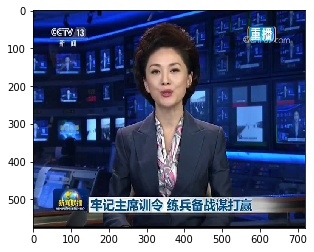

In [32]:
plt.imshow(plt.imread('subFrame/'+str(19381)+'.jpg'))

In [ ]:
print(bgFrame_index,hostList,isYBT)